# Explore lexicon in Vatican publications

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import pymongo

In [3]:
db = pymongo.MongoClient()['vatican']['tokens']

In [18]:
def documents():
    q = {'$group': {'_id': {'pope': '$pope', 'document': '$document'}}}
    docs = []
    for record in db.aggregate([q]):
        docs.append((record['_id']['pope'], record['_id']['document']))
    return docs

In [19]:
docs = documents()

In [20]:
len(docs)

196

In [21]:
[(x, y) for x, y in docs if x == 'Leo XIII']

[('Leo XIII', 'Nobilissima Gallorum Gens'),
 ('Leo XIII', 'Inimica Vis'),
 ('Leo XIII', 'In Ipso'),
 ('Leo XIII', 'Providentissimus Deus'),
 ('Leo XIII', 'Quamquam Pluries'),
 ('Leo XIII', 'Grande Munus'),
 ('Leo XIII', 'Christi Nomen'),
 ('Leo XIII', 'Spectata Fides'),
 ('Leo XIII', 'Longinqua'),
 ('Leo XIII', 'Supremi Apostolatus Officio'),
 ('Leo XIII', 'Immortale Dei'),
 ('Leo XIII', 'Magnae Dei Matris'),
 ('Leo XIII', 'Sapientiae Christianae'),
 ('Leo XIII', 'Quam Aerumnosa'),
 ('Leo XIII', 'Custodi Di Quella Fede'),
 ('Leo XIII', 'Arcanum'),
 ('Leo XIII', 'Fidentem Piumque Animum'),
 ('Leo XIII', 'Non Mediocri'),
 ('Leo XIII', 'Aeterni Patris'),
 ('Leo XIII', 'Quod Auctoritate'),
 ('Leo XIII', 'Satis Cognitum'),
 ('Leo XIII', 'Sancta Dei Civitas'),
 ('Leo XIII', 'Mirae Caritatis'),
 ('Leo XIII', 'Inter Graves'),
 ('Leo XIII', 'Apostolico Seggio'),
 ('Leo XIII', 'Officio Sanctissimo'),
 ('Leo XIII', 'Pastoralis'),
 ('Leo XIII', 'Inscrutabili Dei Consilio'),
 ('Leo XIII', 'Pastoral

## Term Frequency (TF)

$$
tf(d, t) = \frac{count(d, t)}{\max\limits_{i}^{n} count(d, t_i)}
$$

In [22]:
def document_term_count(pope, document, field='lemma'):
    m = {'$match': {'pope': pope, 'document': document}}
    g = {'$group': {'_id': "${}".format(field), 'count': {'$sum': 1}}}
    data = {}
    for record in db.aggregate([m, g]):
        data[record['_id']] = record['count']
    return pd.Series(data)

In [23]:
pope, document = 'Paul VI', 'Humanae Vitae'
tf_count = document_term_count(pope, document)
tf = tf_count / tf_count.max()

In [24]:
tf_count.sort_values(ascending=False).head(10)

,         444
il        406
di il     290
e         220
di        199
.         193
a il      135
essere    127
che       116
uno        80
dtype: int64

In [25]:
tf.sort_values(ascending=False).head(10)

,         1.000000
il        0.914414
di il     0.653153
e         0.495495
di        0.448198
.         0.434685
a il      0.304054
essere    0.286036
che       0.261261
uno       0.180180
dtype: float64

## Document Frequency and Inverse Document Frequency (IDF)

$$
df(t) = \mid\{ d_i : t \in d_i \}\mid
$$

$$
idf(t) = \log \frac{N}{df(t)}
$$

In [26]:
def sentence_df(field='lemma'):
    g = {'$group': {'_id': {'token': "${}".format(field), 'document': "$document", 'sentence': "$sentence"}}}
    g2 = {'$group': {'_id': '$_id.token', 'count': {'$sum': 1}}}
    data = {}
    for record in db.aggregate([g, g2], allowDiskUse=True):
        data[record['_id']] = record['count']
    return pd.Series(data)

def sentence_count():
    g = {'$group': {'_id': {'document': "$document", 'sentence': "$sentence"}}}
    return len([x for x in db.aggregate([g])])

In [27]:
df = sentence_df()
s_count = sentence_count()

In [28]:
s_count

69512

In [29]:
df.sort_values(ascending=False).head(10)

.         50205
,         45529
il        41112
e         31473
di il     29058
di        27873
essere    23354
che       22799
a il      16575
a         15565
dtype: int64

In [30]:
idf = np.log(s_count / df)

In [31]:
idf.sort_values(ascending=False).head(10)

Christophe        11.149255
replicare         11.149255
rispettino        11.149255
TERTULLIANO       11.149255
sant              11.149255
raddrizzamento    11.149255
passero           11.149255
strare            11.149255
totalizzare       11.149255
28).22            11.149255
dtype: float64

## TfIdf

$$
tfidf(d, t) = tf(d, t) \cdot idf(t)
$$

In [32]:
def tfidf(tf, idf, min_idf=0):
    tfidf_data = {}
    for t, tf_x in tf.items():
        idf_w = idf[t]
        if idf_w >= min_idf:
            tfidf_data[t] = tf_x * idf_w 
    return pd.Series(tfidf_data)

In [33]:
tfidf_hv = tfidf(tf, idf, min_idf=4)

In [34]:
tfidf_hv.sort_values(ascending=False).head(10)

coniugale      0.473365
sposo          0.361592
coniuge        0.242326
matrimonio     0.229734
atto           0.219487
regolazione    0.207530
morale         0.198530
naturale       0.173230
natalità       0.168568
paternità      0.165374
dtype: float64

In [35]:
tfidf_hv['matrimonio'], tfidf_hv['lavoro']

(0.22973358579235933, 0.019501073485787893)

In [36]:
import matplotlib.pyplot as plt

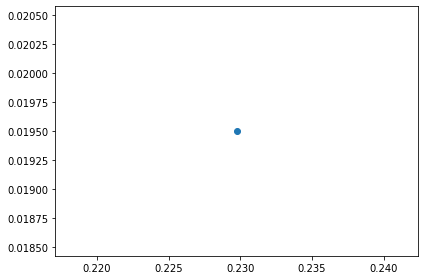

In [37]:
fig, ax = plt.subplots()
ax.scatter([tfidf_hv['matrimonio']], [tfidf_hv['lavoro']])
plt.tight_layout()
plt.show()

In [38]:
def doc_tfidf(pope, document):
    tf_count = document_term_count(pope, document)
    tf = tf_count / tf_count.max()
    tfidf_x = tfidf(tf, idf, min_idf=4)
    return tfidf_x

In [39]:
from collections import defaultdict

In [40]:
d1 = ('Paul VI', 'Humanae Vitae')
d2 = ('Leo XIII', 'Rerum Novarum')
d3 = ('Leo XIII', 'Caritatis')
cases = [d1, d2, d3]
index_docs = defaultdict(lambda: defaultdict(lambda: 0))
for pope, doc in cases:
    data_case = doc_tfidf(pope, doc)
    for word, tfidf_w in data_case.items():
        index_docs["{} {}".format(pope, doc)][word] = tfidf_w

In [41]:
dfr = pd.DataFrame(index_docs).fillna(0)

In [42]:
dfr.sort_values('Leo XIII Rerum Novarum', ascending=False)

,Paul VI Humanae Vitae,Leo XIII Rerum Novarum,Leo XIII Caritatis
operaio,0.000000,0.344368,0.027143
stato,0.019365,0.236363,0.139373
lavoro,0.019501,0.184127,0.043184
società,0.036108,0.166307,0.059970
proprietà,0.000000,0.156526,0.000000
...,...,...,...
verre,0.020162,0.000000,0.000000
rapidamente,0.017527,0.000000,0.000000
accresciuto,0.038668,0.000000,0.000000
prospettiva,0.013766,0.000000,0.000000


In [45]:
dfr.T

,forza,distruggere,punto,pornografia,impedimento,giusto,prettamente,infecondo,eminente,ritrovino,...,ambito,edificare,risplendono,esordio,sette,Sede,ammaestramento,accampare,Basiliano,io
Paul VI Humanae Vitae,0.018414,0.014046,0.011004,0.02355,0.032976,0.043073,0.020728,0.021989,0.017236,0.022637,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Leo XIII Rerum Novarum,0.097533,0.000000,0.005068,0.00000,0.000000,0.054556,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Leo XIII Caritatis,0.142720,0.015553,0.036553,0.00000,0.000000,0.011923,0.000000,0.000000,0.000000,0.000000,...,0.01484,0.017104,0.021824,0.023335,0.017721,0.025505,0.020095,0.026075,0.025064,0.012291


In [43]:
dfr.loc[['matrimonio', 'lavoro']].T

,matrimonio,lavoro
Paul VI Humanae Vitae,0.229734,0.019501
Leo XIII Rerum Novarum,0.005569,0.184127
Leo XIII Caritatis,0.013388,0.043184


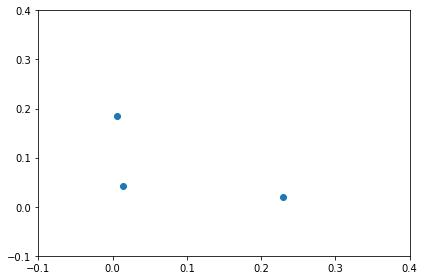

In [44]:
fig, ax = plt.subplots()
ax.scatter(dfr.T['matrimonio'], dfr.T['lavoro'])
ax.set_ylim(-.1, .4)
ax.set_xlim(-.1, .4)
plt.tight_layout()
plt.show()

## Vectors of words

In [57]:
words = dfr[['Leo XIII Rerum Novarum', 'Leo XIII Caritatis']]

In [58]:
words

,Leo XIII Rerum Novarum,Leo XIII Caritatis
forza,0.097533,0.142720
distruggere,0.000000,0.015553
punto,0.005068,0.036553
pornografia,0.000000,0.000000
impedimento,0.000000,0.000000
...,...,...
Sede,0.000000,0.025505
ammaestramento,0.000000,0.020095
accampare,0.000000,0.026075
Basiliano,0.000000,0.025064


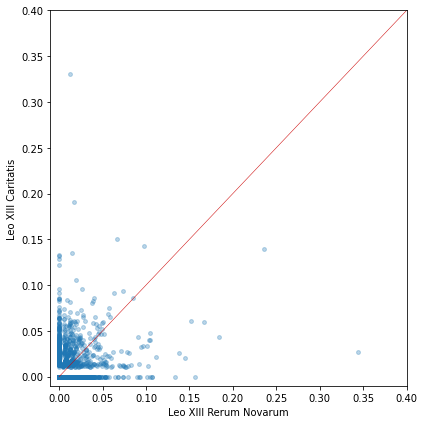

In [66]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(words.T.loc['Leo XIII Rerum Novarum'], 
           words.T.loc['Leo XIII Caritatis'], alpha=.3, s=15)
ax.plot([0, .4], [0, .4], c='#cc0000', linewidth=.5)
ax.set_ylim(-.01, .4)
ax.set_xlim(-.01, .4)
ax.set_xlabel('Leo XIII Rerum Novarum')
ax.set_ylabel('Leo XIII Caritatis')
plt.tight_layout()
plt.show()

$$
y = a x + b
$$

## Euclidean similarity

In [ ]:
v1 = dfr['Paul VI Humanae Vitae'].values
v2 = dfr['Leo XIII Rerum Novarum'].values
v3 = dfr['Leo XIII Caritatis'].values

In [ ]:
np.linalg.norm(v2 - v3)

## Kullback–Leibler divergence

$$
KL(x) = P(x) \log\left(\frac{P(x)}{Q(x)}\right)
$$

In [68]:
def generate_filter(pope, document):
    return {'$match': {'pope': pope, 'document': document}}

def term_count(field='lemma', m=None):
    g = {'$group': {'_id': "${}".format(field), 'count': {'$sum': 1}}}
    data = {}
    if m is None:
        pipeline = [g]
    else:
        pipeline = [m, g]
    for record in db.aggregate(pipeline):
        data[record['_id']] = record['count']
    return pd.Series(data)

In [72]:
freq_star = term_count()
freq_star_n = freq_star / freq_star.sum()

In [73]:
freq_star_n.sort_values(ascending=False)

,                7.092050e-02
il               5.931947e-02
e                3.351192e-02
di il            3.310505e-02
.                3.016209e-02
                     ...     
corpo.86         5.930998e-07
eguagliare       5.930998e-07
provvedere li    5.930998e-07
convinre         5.930998e-07
patema           5.930998e-07
Length: 43723, dtype: float64

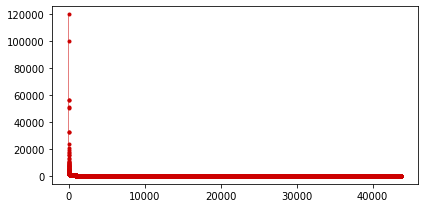

In [80]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(freq_star.sort_values(ascending=False).values, c='#cc0000', linewidth=.5, marker='.')
plt.tight_layout()
plt.show()

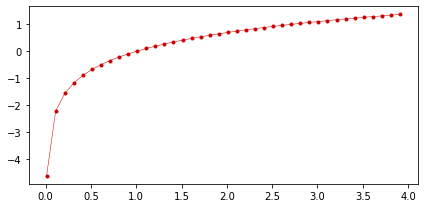

In [108]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(np.arange(0.01, 4, .1), np.log(np.arange(0.01, 4, .1)), c='#cc0000', linewidth=.5, marker='.')
plt.tight_layout()
plt.show()

In [94]:
freq_hv = term_count(m=generate_filter('Paul VI', 'Humanae Vitae'))
freq_hv_n = freq_hv / freq_hv.sum()

In [95]:
freq_hv_n.sort_values(ascending=False)

,              0.067611
il             0.061824
di il          0.044160
e              0.033501
di             0.030303
                 ...   
integralità    0.000152
luglio         0.000152
linguaggio     0.000152
degno          0.000152
accettare      0.000152
Length: 1381, dtype: float64

In [100]:
word = 'laico'
print(freq_hv_n[word], freq_star_n[word], freq_hv_n[word] / freq_star_n[word])
print(np.log(freq_hv_n[word] / freq_star_n[word]))

0.00015227653418608191 0.00011802685199847929 1.2901855095486567
0.2547860138861823


In [118]:
vocabulary = freq_hv_n.index.values
kl_hv = freq_hv_n * np.log(freq_hv_n / freq_star_n[vocabulary])

In [120]:
kl_hv.sort_values(ascending=False).head(10)

coniugale      0.021541
sposo          0.015181
di il          0.012724
coniuge        0.009076
regolazione    0.008666
a il           0.007861
matrimonio     0.007541
atto           0.006759
natalità       0.006732
legge          0.006436
dtype: float64

In [15]:
def get_sentences(pope, document, field='lemma'):
    q = {'$group': {'_id': {'pope': '$pope', 'document': '$document', 'sentence': '$sentence'}, 
                    'tokens': {'$push': {'sentence': '$sentence', 
                                         'token': '${}'.format(field),
                                         'idx': '$idx',
                                         'pos': '$pos'
                                        }}}}
    docs = []
    sentence, previous = [], -1
    for record in db.aggregate([q], allowDiskUse=True):
        docs.append(record['tokens'])
    return docs

In [16]:
sentences = get_sentences('Paul VI', 'Humanae Vitae')